# Shaper Traning

In [1]:
import cv2
import imutils
import time
import kornia
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.weight_norm as weightNorm
import random
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [2]:
def make_mask_noop(action, width, height, wmin, wmax, hmin, hmax):
    # Shape
    x, y = (action[:, 1:2]-0.5)*width, (action[:, 2:3]-0.5)*height
    w = (action[:, 3:4]*(wmax-wmin)+wmin)*width
    h = (action[:, 4:5]*(hmax-hmin)+hmin)*height
    x *= (width-w)/(width)
    y *= (height-h)/(height)
    sx1, sy1 = width/2 - w/2 + w*action[:, 5:6], height/2 + h/2
    sx2, sy2 = width/2 + w/2, height/2 - h/2 + h*action[:, 8:9]
    sx3, sy3 = width/2 - w/2 + w*action[:, 6:7], height/2 - h/2
    sx4, sy4 = width/2 - w/2, height/2 - h/2 + h*action[:, 7:8]

    sp1 = torch.cat([sx1, sy1], 1)
    sp2 = torch.cat([sx2, sy2], 1)
    sp3 = torch.cat([sx3, sy3], 1)
    sp4 = torch.cat([sx4, sy4], 1)

    base = torch.zeros([action.size(0), 1, height, width]).cuda()
    polygons = torch.stack([sp1, sp2, sp3, sp4], 1)
    colors = torch.ones([action.size(0), 1]).cuda()
    shape = kornia.utils.draw_convex_polygon(base, polygons, colors)
    
    # Translate mask
    tm = torch.cat([x, y], 1)
    mask = kornia.geometry.transform.translate(shape, tm)
    
    # noop
    mask = mask * (action[:, 0:1] > 0.5).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, height, width)
    
    return mask

tensor([[0.8508, 0.1019, 0.3499, 0.7585, 0.3031, 0.0136, 0.2245, 0.3061, 0.9146,
         0.7563]], device='cuda:0')


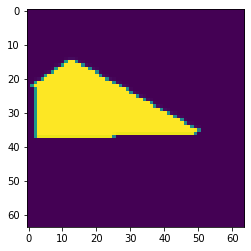

In [3]:
# Test shaping
width, height = 64, 64
wmin, wmax = 0.1, 1.0
hmin, hmax = 0.1, 1.0
action = torch.rand([1, 10]).cuda()
print(action)
gt_mask = make_mask_noop(action, width, height, 0.1, 1.0, 0.1, 1.0)[0].detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(gt_mask)

In [4]:


class Shaper(nn.Module):
    def __init__(self):
        super(Shaper, self).__init__()
        # 128x128
#         self.fc1 = (nn.Linear(9, 512))
#         self.fc2 = (nn.Linear(512, 1024))
#         self.fc3 = (nn.Linear(1024, 2048))
#         self.fc4 = (nn.Linear(2048, 4096))
#         self.conv1 = (nn.Conv2d(16, 32, 3, 1, 1))
#         self.conv2 = (nn.Conv2d(32, 32, 3, 1, 1))
#         self.conv3 = (nn.Conv2d(8, 16, 3, 1, 1))
#         self.conv4 = (nn.Conv2d(16, 16, 3, 1, 1))
#         self.conv5 = (nn.Conv2d(4, 8, 3, 1, 1))
#         self.conv6 = (nn.Conv2d(8, 4, 3, 1, 1))
#         self.pixel_shuffle = nn.PixelShuffle(2)
        
        # 64x64
        self.fc1 = (nn.Linear(9, 512))
        self.fc2 = (nn.Linear(512, 1024))
        self.fc3 = (nn.Linear(1024, 2048))
        self.conv1 = (nn.Conv2d(8, 16, 3, 1, 1))
        self.conv2 = (nn.Conv2d(16, 16, 3, 1, 1))
        self.conv3 = (nn.Conv2d(4, 8, 3, 1, 1))
        self.conv4 = (nn.Conv2d(8, 8, 3, 1, 1))
        self.conv5 = (nn.Conv2d(2, 4, 3, 1, 1))
        self.conv6 = (nn.Conv2d(4, 1, 3, 1, 1))
        self.pixel_shuffle = nn.PixelShuffle(2)

    def forward(self, x):        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
#         x = F.relu(self.fc4(x))  # 128x128
#         x = x.view(-1, 16, 16, 16)  # 128x128
        x = x.view(-1, 8, 16, 16)  # 64x64
        x = F.relu(self.conv1(x))
        x = self.pixel_shuffle(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.conv6(x)  # 64x64
#         x = self.pixel_shuffle(self.conv6(x))  # 128x128
        x = torch.sigmoid(x)
#         return 1 - x.view(-1, 1, 128, 128)  # 128x128
        return 1 - x.view(-1, 1, 64, 64)  # 64x64

  0%|          | 13/200000 [00:00<1:01:57, 53.80it/s]

tensor(0.2536, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|          | 1023/200000 [00:07<22:56, 144.52it/s]

tensor(0.0343, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|          | 2028/200000 [00:13<20:58, 157.28it/s]

tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)


  2%|▏         | 3018/200000 [00:20<20:54, 156.98it/s]

tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)


  2%|▏         | 4018/200000 [00:26<21:20, 153.10it/s]

tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 5015/200000 [00:33<21:44, 149.50it/s]

tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 6022/200000 [00:40<20:58, 154.11it/s]

tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▎         | 7019/200000 [00:46<22:17, 144.34it/s]

tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 8029/200000 [00:53<21:00, 152.34it/s]

tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)


  5%|▍         | 9017/200000 [01:00<20:26, 155.65it/s]

tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)


  5%|▌         | 10017/200000 [01:06<20:41, 153.09it/s]

tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▌         | 11019/200000 [01:13<20:54, 150.67it/s]

tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▌         | 12020/200000 [01:20<20:36, 152.01it/s]

tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 13017/200000 [01:26<19:58, 156.04it/s]

tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 14017/200000 [01:33<20:41, 149.77it/s]

tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 15025/200000 [01:40<20:13, 152.45it/s]

tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 16021/200000 [01:46<20:07, 152.38it/s]

tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward0>)


  9%|▊         | 17018/200000 [01:53<20:33, 148.34it/s]

tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward0>)


  9%|▉         | 18025/200000 [02:00<19:51, 152.70it/s]

tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 19024/200000 [02:06<21:04, 143.10it/s]

tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|█         | 20019/200000 [02:13<19:29, 153.94it/s]

tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward0>)


 11%|█         | 21016/200000 [02:20<19:52, 150.13it/s]

tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)


 11%|█         | 22019/200000 [02:26<19:32, 151.74it/s]

tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 23015/200000 [02:33<20:40, 142.67it/s]

tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 24020/200000 [02:40<20:28, 143.19it/s]

tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 25018/200000 [02:47<20:03, 145.43it/s]

tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 26022/200000 [02:53<19:23, 149.50it/s]

tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▎        | 27030/200000 [03:00<18:51, 152.85it/s]

tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▍        | 28015/200000 [03:07<19:34, 146.37it/s]

tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▍        | 29017/200000 [03:14<19:01, 149.77it/s]

tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 30021/200000 [03:20<18:42, 151.49it/s]

tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▌        | 31022/200000 [03:27<20:33, 137.04it/s]

tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▌        | 32024/200000 [03:34<18:26, 151.78it/s]

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 33024/200000 [03:40<18:20, 151.67it/s]

tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 34022/200000 [03:47<19:49, 139.52it/s]

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 35017/200000 [03:54<19:00, 144.72it/s]

tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 36032/200000 [04:01<17:52, 152.91it/s]

tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▊        | 37026/200000 [04:07<18:26, 147.32it/s]

tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▉        | 38025/200000 [04:14<18:29, 146.05it/s]

tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 39017/200000 [04:21<17:38, 152.04it/s]

tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|██        | 40017/200000 [04:28<18:03, 147.67it/s]

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 41019/200000 [04:34<18:08, 146.02it/s]

tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 42020/200000 [04:41<18:51, 139.64it/s]

tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 43023/200000 [04:48<17:44, 147.46it/s]

tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 44020/200000 [04:55<17:34, 147.89it/s]

tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)


 23%|██▎       | 45028/200000 [05:02<17:54, 144.26it/s]

tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)


 23%|██▎       | 46024/200000 [05:08<17:33, 146.12it/s]

tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▎       | 47023/200000 [05:15<17:21, 146.82it/s]

tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 48030/200000 [05:22<16:50, 150.39it/s]

tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▍       | 49022/200000 [05:29<16:49, 149.57it/s]

tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▌       | 50018/200000 [05:35<16:45, 149.11it/s]

tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 51016/200000 [05:42<16:25, 151.21it/s]

tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 52021/200000 [05:49<16:45, 147.14it/s]

tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 53023/200000 [05:56<15:57, 153.58it/s]

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 54021/200000 [06:03<17:15, 140.93it/s]

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 55024/200000 [06:09<15:53, 152.12it/s]

tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 56021/200000 [06:16<17:25, 137.65it/s]

tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▊       | 57020/200000 [06:23<15:39, 152.25it/s]

tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 58017/200000 [06:30<16:25, 144.07it/s]

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|██▉       | 59017/200000 [06:37<15:29, 151.73it/s]

tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|███       | 60020/200000 [06:44<16:08, 144.57it/s]

tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███       | 61023/200000 [06:50<15:32, 149.08it/s]

tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███       | 62026/200000 [06:57<15:40, 146.68it/s]

tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 63021/200000 [07:04<15:07, 151.01it/s]

tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 64018/200000 [07:11<16:14, 139.55it/s]

tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 65029/200000 [07:18<15:00, 149.84it/s]

tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 66028/200000 [07:24<15:22, 145.25it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▎      | 67020/200000 [07:31<15:34, 142.30it/s]

tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▍      | 68022/200000 [07:38<14:37, 150.45it/s]

tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▍      | 69017/200000 [07:45<14:24, 151.59it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 70017/200000 [07:52<14:48, 146.25it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▌      | 71031/200000 [07:59<14:21, 149.77it/s]

tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▌      | 72020/200000 [08:06<15:06, 141.24it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


 37%|███▋      | 73018/200000 [08:12<15:37, 135.44it/s]

tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)


 37%|███▋      | 74021/200000 [08:19<13:47, 152.32it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 75028/200000 [08:26<14:08, 147.25it/s]

tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 76021/200000 [08:33<14:02, 147.16it/s]

tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)


 39%|███▊      | 77022/200000 [08:40<13:51, 147.92it/s]

tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)


 39%|███▉      | 78019/200000 [08:46<15:04, 134.85it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|███▉      | 79023/200000 [08:53<13:07, 153.62it/s]

tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|████      | 80019/200000 [09:00<13:39, 146.42it/s]

tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 81030/200000 [09:07<13:10, 150.41it/s]

tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 82021/200000 [09:14<13:26, 146.22it/s]

tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 83016/200000 [09:21<12:53, 151.30it/s]

tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 84025/200000 [09:28<13:07, 147.28it/s]

tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward0>)


 43%|████▎     | 85024/200000 [09:34<12:38, 151.62it/s]

tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward0>)


 43%|████▎     | 86019/200000 [09:41<13:19, 142.55it/s]

tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 87020/200000 [09:48<12:33, 149.87it/s]

tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▍     | 88021/200000 [09:55<13:29, 138.25it/s]

tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▍     | 89019/200000 [10:02<12:54, 143.29it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▌     | 90016/200000 [10:08<11:55, 153.67it/s]

tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▌     | 91030/200000 [10:15<12:08, 149.56it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▌     | 92027/200000 [10:22<12:26, 144.59it/s]

tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 93030/200000 [10:29<11:58, 148.83it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 94015/200000 [10:36<12:33, 140.59it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 48%|████▊     | 95020/200000 [10:42<11:48, 148.22it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 48%|████▊     | 96022/200000 [10:49<11:48, 146.74it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▊     | 97024/200000 [10:56<11:38, 147.35it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 98026/200000 [11:03<11:58, 141.99it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 50%|████▉     | 99016/200000 [11:10<11:21, 148.19it/s]

tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


 50%|█████     | 100018/200000 [11:17<12:00, 138.69it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 101026/200000 [11:23<11:06, 148.43it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 102027/200000 [11:30<11:11, 145.82it/s]

tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 103022/200000 [11:37<10:41, 151.10it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 104030/200000 [11:44<11:18, 141.50it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 53%|█████▎    | 105017/200000 [11:51<10:22, 152.66it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 53%|█████▎    | 106021/200000 [11:57<10:51, 144.30it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▎    | 107026/200000 [12:04<10:18, 150.30it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 108029/200000 [12:11<10:34, 144.90it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▍    | 109028/200000 [12:18<10:11, 148.67it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▌    | 110020/200000 [12:25<10:06, 148.36it/s]

tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▌    | 111025/200000 [12:32<10:47, 137.40it/s]

tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▌    | 112021/200000 [12:38<09:49, 149.34it/s]

tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward0>)


 57%|█████▋    | 113027/200000 [12:45<10:01, 144.68it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 57%|█████▋    | 114031/200000 [12:52<09:36, 149.08it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 115022/200000 [12:59<10:39, 132.83it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 116024/200000 [13:06<09:20, 149.86it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▊    | 117029/200000 [13:13<09:10, 150.80it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 118027/200000 [13:19<09:24, 145.26it/s]

tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|█████▉    | 119021/200000 [13:26<09:16, 145.46it/s]

tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|██████    | 120024/200000 [13:33<08:59, 148.22it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 121022/200000 [13:40<09:41, 135.78it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 122028/200000 [13:47<08:35, 151.18it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▏   | 123022/200000 [13:53<08:43, 147.10it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▏   | 124021/200000 [14:00<08:59, 140.72it/s]

tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 125030/200000 [14:07<08:28, 147.49it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 126024/200000 [14:14<08:26, 145.92it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 64%|██████▎   | 127027/200000 [14:21<08:25, 144.43it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 64%|██████▍   | 128019/200000 [14:27<08:13, 145.87it/s]

tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▍   | 129031/200000 [14:34<07:50, 150.76it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▌   | 130022/200000 [14:41<08:29, 137.30it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 131024/200000 [14:48<07:48, 147.36it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 132023/200000 [14:55<08:03, 140.62it/s]

tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 133027/200000 [15:02<07:33, 147.58it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 134027/200000 [15:08<07:28, 147.05it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 135019/200000 [15:15<07:13, 149.95it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 136030/200000 [15:22<07:35, 140.35it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▊   | 137015/200000 [15:29<06:59, 150.23it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 138028/200000 [15:36<07:06, 145.25it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|██████▉   | 139017/200000 [15:42<06:50, 148.74it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|███████   | 140024/200000 [15:49<06:29, 153.81it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 71%|███████   | 141019/200000 [15:56<06:53, 142.68it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


 71%|███████   | 142032/200000 [16:03<06:18, 153.30it/s]

tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 143030/200000 [16:10<06:24, 148.24it/s]

tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 144026/200000 [16:17<06:12, 150.28it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 145025/200000 [16:23<06:16, 145.86it/s]

tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 146021/200000 [16:30<05:55, 152.04it/s]

tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▎  | 147016/200000 [16:37<06:02, 146.34it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▍  | 148017/200000 [16:44<05:37, 153.80it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 149025/200000 [16:51<05:50, 145.60it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▌  | 150017/200000 [16:57<05:31, 150.62it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 151026/200000 [17:04<05:50, 139.87it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 152013/200000 [17:11<05:27, 146.38it/s]

tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 153025/200000 [17:18<05:15, 148.93it/s]

tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 154028/200000 [17:25<05:04, 151.03it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 78%|███████▊  | 155021/200000 [17:31<05:08, 145.81it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 78%|███████▊  | 156018/200000 [17:38<04:55, 148.76it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▊  | 157015/200000 [17:45<05:25, 132.08it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 158032/200000 [17:52<04:31, 154.61it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|███████▉  | 159023/200000 [17:59<04:34, 149.11it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 160031/200000 [18:05<04:28, 148.88it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████  | 161031/200000 [18:12<04:14, 152.95it/s]

tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████  | 162013/200000 [18:19<04:18, 146.69it/s]

tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 163020/200000 [18:26<04:06, 150.09it/s]

tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 164017/200000 [18:32<04:02, 148.50it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 165029/200000 [18:39<03:56, 147.98it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 166011/200000 [18:46<04:07, 137.46it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▎ | 167026/200000 [18:53<03:41, 149.07it/s]

tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 168022/200000 [19:00<03:32, 150.81it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▍ | 169031/200000 [19:07<03:30, 146.98it/s]

tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▌ | 170022/200000 [19:13<03:18, 150.98it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 171022/200000 [19:20<03:40, 131.41it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 172027/200000 [19:27<03:07, 149.14it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 173019/200000 [19:34<02:55, 153.52it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 174030/200000 [19:40<02:51, 151.51it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 186026/200000 [21:02<01:34, 148.58it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▎| 187021/200000 [21:09<01:25, 151.05it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 188017/200000 [21:16<01:23, 144.11it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▍| 189024/200000 [21:22<01:16, 143.83it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▌| 190025/200000 [21:29<01:06, 150.02it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▌| 191017/200000 [21:36<00:59, 149.95it/s]

tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▌| 192027/200000 [21:43<00:53, 149.97it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 193027/200000 [21:49<00:48, 145.24it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 194025/200000 [21:56<00:43, 138.89it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 98%|█████████▊| 195022/200000 [22:03<00:35, 139.00it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 98%|█████████▊| 196028/200000 [22:10<00:26, 148.53it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▊| 197017/200000 [22:17<00:19, 150.88it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▉| 198019/200000 [22:24<00:13, 146.27it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|█████████▉| 199024/200000 [22:30<00:06, 151.70it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 200000/200000 [22:37<00:00, 147.33it/s]


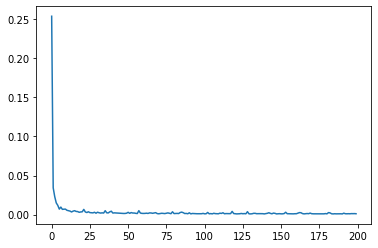

In [5]:
shaper = Shaper().cuda()
shaper_optim = optim.Adam(shaper.parameters(), lr=0.0001)
criterion = nn.MSELoss()

width, height = 64, 64
wmin, wmax = 0.1, 1.0
hmin, hmax = 0.1, 1.0

losses = []
for i in tqdm(range(200000)):
    bs = 128
    random_action = torch.rand([bs, 9]).cuda()
    gt_mask = make_mask_noop(random_action, width, height, wmin, wmax, hmin, hmax)
    pred_shape = shaper(random_action)
    loss = criterion(pred_shape, gt_mask)  # masker
    shaper_optim.zero_grad()
    loss.backward()
    shaper_optim.step()
    
    if i % 1000 == 0:
        losses.append(loss.item())
        print(loss)
plt.plot(losses)

In [55]:
# Save weight
torch.save(shaper.state_dict(), 'shaper0110snoop.pkl')

tensor([[0.6295, 0.1605, 0.1958, 0.5520, 0.4714, 0.2858, 0.8878, 0.8981, 0.4826]],
       device='cuda:0')


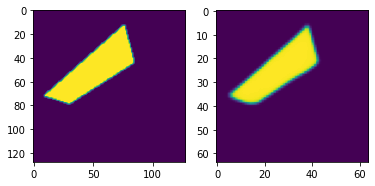

In [7]:
## Neural Shaper Testing
width, height = 128, 128
shaper.eval()

# Random action
action = torch.rand([1, 9]).cuda()
print(action)

# Custom action
# action = torch.FloatTensor([1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]).unsqueeze(0).cuda()

gt_mask = make_mask_noop(action, width, height, 0.1, 1.0, 0.1, 1.0)[0].detach().cpu().numpy().transpose(1, 2, 0)
pred_shape = shaper(action)[0].detach().cpu().numpy().transpose(1, 2, 0)
plt.subplot(1, 2, 1)
plt.imshow(gt_mask)
plt.subplot(1, 2, 2)
plt.imshow(pred_shape)

In [8]:
# Draw function using trained Shaper
def draw_diff(canvas, source, action, width, height, wmin, wmax, hmin, hmax, restrict_inside=False, paper_like=False):
    mask = shaper(action[:, :9])

    piece = source * mask
    
    # Translate & rotation
    x, y = (action[:, 1:2]-0.5)*width, (action[:, 2:3]-0.5)*height
    w = (action[:, 3:4]*(wmax-wmin)+wmin)*width
    h = (action[:, 4:5]*(hmax-hmin)+hmin)*height
    x *= (width-w)/(width)
    y *= (height-h)/(height)
    px = (action[:, 9:10]-0.5)*width - x
    py = (action[:, 10:11]-0.5)*height - y
    pr = action[:, 11] * 180 - 90
    pt = torch.cat([px, py], 1)
    ptrm = kornia.geometry.transform.get_affine_matrix2d(translations=pt,
                                                         center=torch.FloatTensor([width/2, height/2]).unsqueeze(0).repeat(canvas.size(0), 1).cuda(),
                                                         scale=torch.ones([canvas.size(0), 2]).cuda(),
                                                         angle=pr)
    transformed_piece = kornia.geometry.warp_affine(piece, ptrm[:, :2, :], (width, height))
    transformed_mask = kornia.geometry.warp_affine(mask, ptrm[:, :2, :], (width, height))

    next_canvas = canvas*(1 - transformed_mask) + transformed_piece

    return next_canvas, transformed_mask

100%|██████████| 1/1 [00:00<00:00, 389.95it/s]

tensor([[1.0000, 0.6000, 0.3000, 0.7000, 0.7000, 0.3000, 0.1000, 0.7000, 0.4000,
         0.8000, 0.6000, 0.2000]], device='cuda:0')


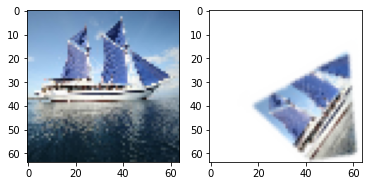

In [9]:
# width, height = 128, 128
width, height = 64, 64
with torch.no_grad():
    canvas = torch.ones([3, height, width]).unsqueeze(0).cuda()
    source = cv2.cvtColor(cv2.imread('../samples/goals/boat.jpg'), cv2.COLOR_BGR2RGB)/255
    source = cv2.resize(source, (width, height))
    source = torch.FloatTensor(source.transpose(2, 0, 1)).unsqueeze(0).repeat(canvas.size(0), 1, 1, 1).cuda()
    for i in tqdm(range(1)):
        # Custom action
        action = torch.FloatTensor([1.0, 0.6, 0.3, 0.7, 0.7, 0.3, 0.1, 0.7, 0.4, 0.8, 0.6, 0.2]).unsqueeze(0).cuda()
        # Random action
        # action = torch.rand([12]).unsqueeze(0).cuda()
        canvas, _ = draw_diff(canvas, source, action, width, height, wmin, wmax, hmin, hmax, paper_like=False)
    plt.subplot(1, 2, 1)
    plt.imshow(source[0].detach().cpu().numpy().transpose(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(canvas[0].detach().cpu().numpy().transpose(1, 2, 0))
print(action)

# Differentiability Testing

100%|██████████| 1/1 [00:00<00:00, 355.54it/s]


tensor(0.0518, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0427, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0379, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0160, device='cuda:0', grad_fn=

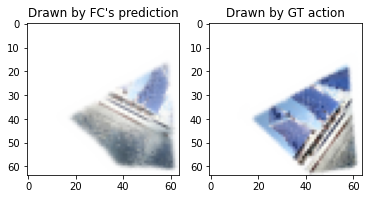

In [10]:
action_dim = 12
# Custom action
action = torch.FloatTensor([1.0, 0.6, 0.3, 0.7, 0.7, 0.3, 0.1, 0.7, 0.4, 0.8, 0.6, 0.2]).unsqueeze(0).cuda()
# Random action
# action = torch.rand([12]).unsqueeze(0).cuda()

canvas = torch.ones([3, height, width]).unsqueeze(0).cuda()
source = cv2.cvtColor(cv2.imread('../samples/goals/boat.jpg'), cv2.COLOR_BGR2RGB)/255
source = cv2.resize(source, (width, height))
source = torch.FloatTensor(source.transpose(2, 0, 1)).unsqueeze(0).repeat(canvas.size(0), 1, 1, 1).cuda()
for i in tqdm(range(1)):
    # Custom action
    action = torch.FloatTensor([1.0, 0.6, 0.3, 0.7, 0.7, 0.3, 0.1, 0.7, 0.4, 0.8, 0.6, 0.2]).unsqueeze(0).cuda()
    # Random action
    # action = torch.rand([12]).unsqueeze(0).cuda()
    with torch.no_grad():
        canvas, _ = draw_diff(canvas, source, action, width, height, wmin, wmax, hmin, hmax, paper_like=False)


class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        action = self.fc(x)
        return action
    
actor = FC().cuda()
optimizer = optim.Adam(actor.parameters(), lr=0.0003)
criterion = nn.MSELoss()

x = torch.rand([1]).unsqueeze(0).cuda()
for i in range(2000):
    empty_canvas = torch.ones([3, height, width]).unsqueeze(0).cuda()
    loss = criterion(draw_diff(empty_canvas, source, actor(x), width, height, wmin, wmax, hmin, hmax, paper_like=False)[0], canvas)
    if i % 100 == 0:
        print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print(f'FC\'s prediction: {actor(x)}')
print(f'GT: {action}')
empty_canvas = torch.ones([3, height, width]).unsqueeze(0).cuda()
sample_output = draw_diff(empty_canvas, source, actor(x), width, height, wmin, wmax, hmin, hmax, paper_like=False)[0][0].detach().cpu().numpy().transpose(1, 2, 0)
plt.subplot(1, 2, 1)
plt.title(f'Drawn by FC\'s prediction')
plt.imshow(sample_output)
plt.subplot(1, 2, 2)
plt.title(f'Drawn by GT action')
plt.imshow(canvas[0].detach().cpu().numpy().transpose(1, 2, 0))